In [36]:
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import folium
import requests
import urllib
from bs4 import BeautifulSoup as bs
%matplotlib inline

# 1. Import the Risk Register data from 3GRC (in a .csv format)

In [16]:
# Import the file
df = pd.read_csv("Risk Register.csv")
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      1379 non-null   int64  
 1   description                             1379 non-null   object 
 2   scenario                                1379 non-null   object 
 3   likelihood                              1379 non-null   int64  
 4   overall_impact                          1379 non-null   int64  
 5   estimated_completion_date               153 non-null    object 
 6   estimated_cost                          99 non-null     float64
 7   status                                  1379 non-null   int64  
 8   recommendation                          78 non-null     object 
 9   risk_name                               1379 non-null   object 
 10  risk_description                        1379 non-null   obje

# 2. Data cleaning and data wrangling

In [3]:
df.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      1379 non-null   int64  
 1   description                             1379 non-null   object 
 2   scenario                                1379 non-null   object 
 3   likelihood                              1379 non-null   int64  
 4   overall_impact                          1379 non-null   int64  
 5   estimated_completion_date               153 non-null    object 
 6   estimated_cost                          99 non-null     float64
 7   status                                  1379 non-null   int64  
 8   recommendation                          78 non-null     object 
 9   risk_name                               1379 non-null   object 
 10  risk_description                        1379 non-null   obje

In [17]:
# We need to drop a few columns that we will not be using in this analysis. 
df.drop(['Supporting Evidence.8', 'Actions Taken to Reduce the Exposure.8', 'Supporting Evidence.7', 'Actions Taken to Reduce the Exposure.7', 'Supporting Evidence.6', 'Actions Taken to Reduce the Exposure.6', 'Supporting Evidence.5', 'Actions Taken to Reduce the Exposure.5'], axis=1, inplace=True)
df.drop(['Gross Exposure (£m)', 'Supporting Evidence.4', 'Actions Taken to Reduce the Exposure.4', 'Supporting Evidence.3', 'Actions Taken to Reduce the Exposure.3', 'Supporting Evidence.1', 'Actions Taken to Reduce the Exposure.2', 'CVSS', 'Manually Verified'], axis=1, inplace=True)      

In [ ]:
# Remove the Google Entities

# 2. Run a graph of the overall risk types to assess important categories

<AxesSubplot:xlabel='risk_type', ylabel='overall_score'>

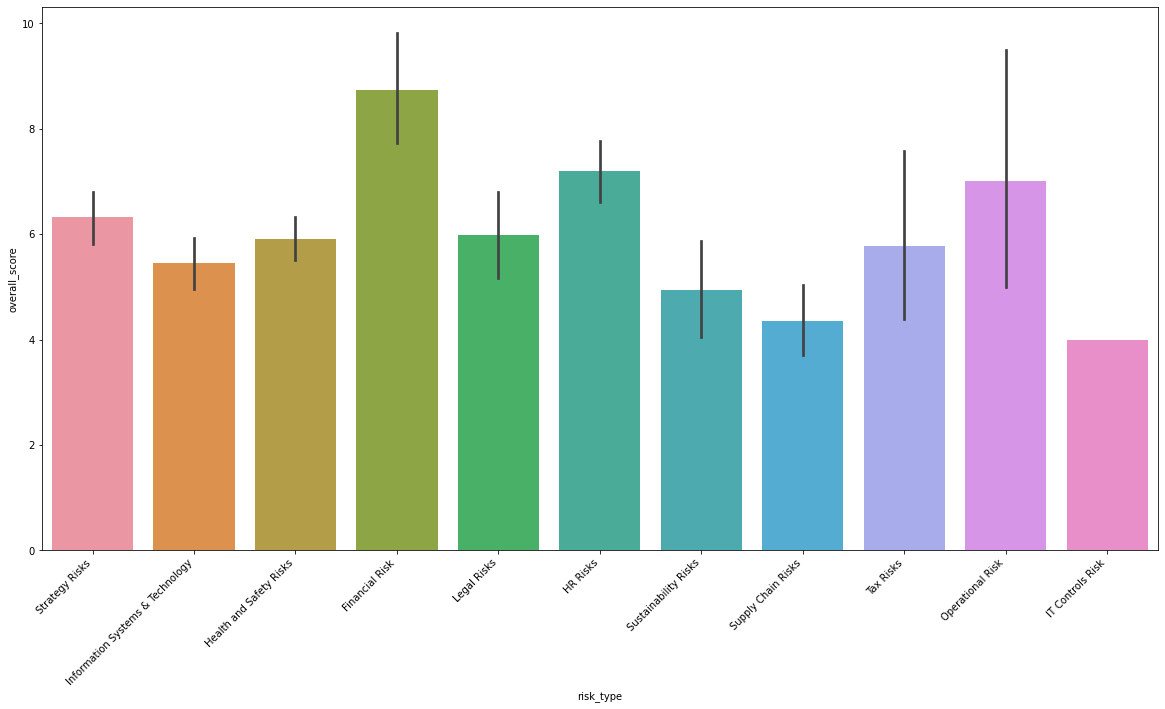

In [18]:
plt.pyplot.figure(figsize=[20,10])
plt.pyplot.xticks(fontsize=10, rotation = 45, ha="right")
plt.pyplot.yticks(fontsize=10)
sns.barplot(x="risk_type", y="overall_score", data=df, order=None,hue_order=None, orient=None, color=None, palette=None)

# 3. Identify the entities with the total risk scores

<AxesSubplot:xlabel='entity_name', ylabel='overall_score'>

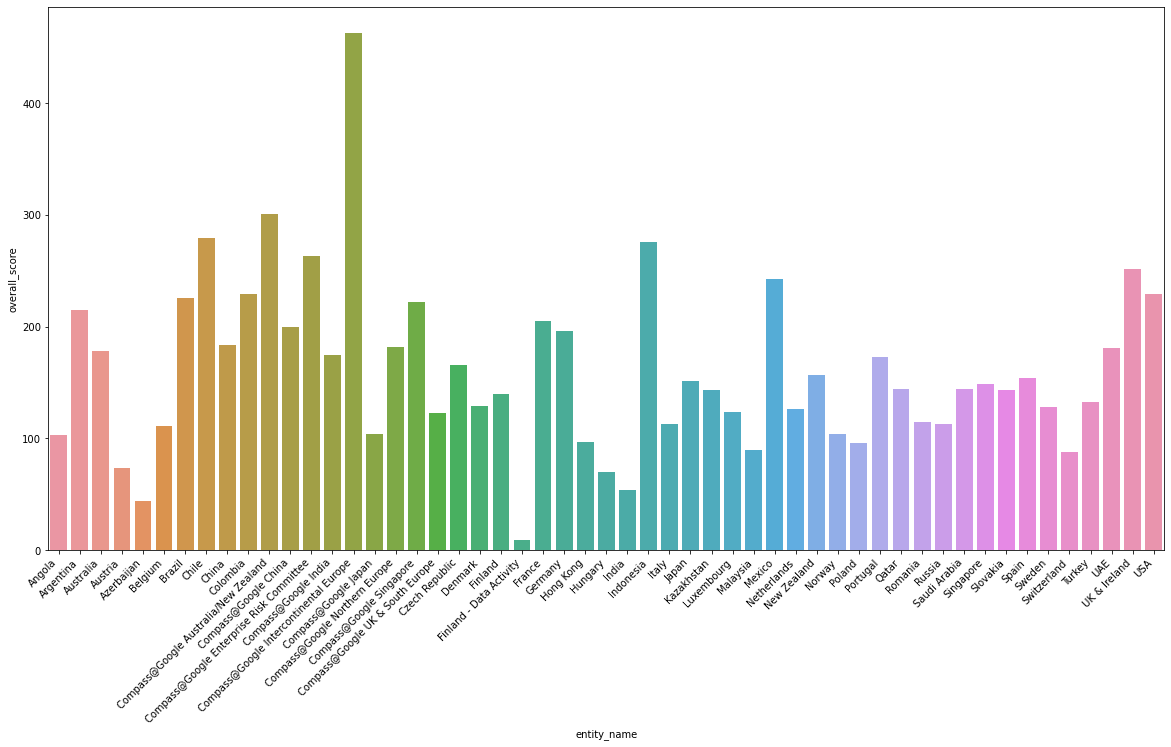

In [21]:
df_entities = df.groupby(by=["entity_name"],as_index=False).sum()
#df_entities.info()
df_entities.groupby(by=["overall_score"], dropna=False).sum()
plt.pyplot.figure(figsize=[20,10])
plt.pyplot.xticks(fontsize=10, rotation = 45, ha="right")
plt.pyplot.yticks(fontsize=10)
sns.barplot(x="entity_name", y="overall_score", data=df_entities, order=None, hue_order=None, orient=None, color=None, palette=None)

# 4. We need to bring in the country coordinates to be able to place these on a map

In [22]:
#Webscraping longitude and latitude data
url = 'http://techslides.com/list-of-countries-and-capitals'
df_coordinates = pd.read_html(url, header=0)
df_coordinates = df_coordinates[0]
df_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Name       245 non-null    object 
 1   Capital Name       241 non-null    object 
 2   Capital Latitude   245 non-null    float64
 3   Capital Longitude  245 non-null    float64
 4   Country Code       242 non-null    object 
 5   Continent Name     245 non-null    object 
dtypes: float64(2), object(4)
memory usage: 11.6+ KB


In [23]:
# Rename the country column so that it can be merged with the main risk file
df_coordinates=df_coordinates.rename(columns={"Country Name": "entity_name"})
df_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   entity_name        245 non-null    object 
 1   Capital Name       241 non-null    object 
 2   Capital Latitude   245 non-null    float64
 3   Capital Longitude  245 non-null    float64
 4   Country Code       242 non-null    object 
 5   Continent Name     245 non-null    object 
dtypes: float64(2), object(4)
memory usage: 11.6+ KB


In [24]:
#We can now merge the datafiles
df_complete = pd.merge(df_entities, df_coordinates, on='entity_name')
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   entity_name                             40 non-null     object 
 1   id                                      40 non-null     int64  
 2   likelihood                              40 non-null     int64  
 3   overall_impact                          40 non-null     int64  
 4   estimated_cost                          40 non-null     float64
 5   status                                  40 non-null     int64  
 6   entity_id                               40 non-null     int64  
 7   overall_score                           40 non-null     int64  
 8   survey_question                         40 non-null     float64
 9   comments_count                          40 non-null     int64  
 10  documents_count                         40 non-null     int64  


In [26]:
# add markers to map
for lat, lng, entity_name in zip(df_complete['Capital Latitude'], df_complete['Capital Longitude'], df_complete['entity_name']):
    label = '{}'.format(entity_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=)False.add_to(risk_map)  
risk_map

SyntaxError: invalid syntax (<ipython-input-26-bcbf7cb97165>, line 13)

# 4a. Identify the entities with the total risk scores and provide a quick visual of the results

<AxesSubplot:xlabel='entity_name', ylabel='overall_score'>

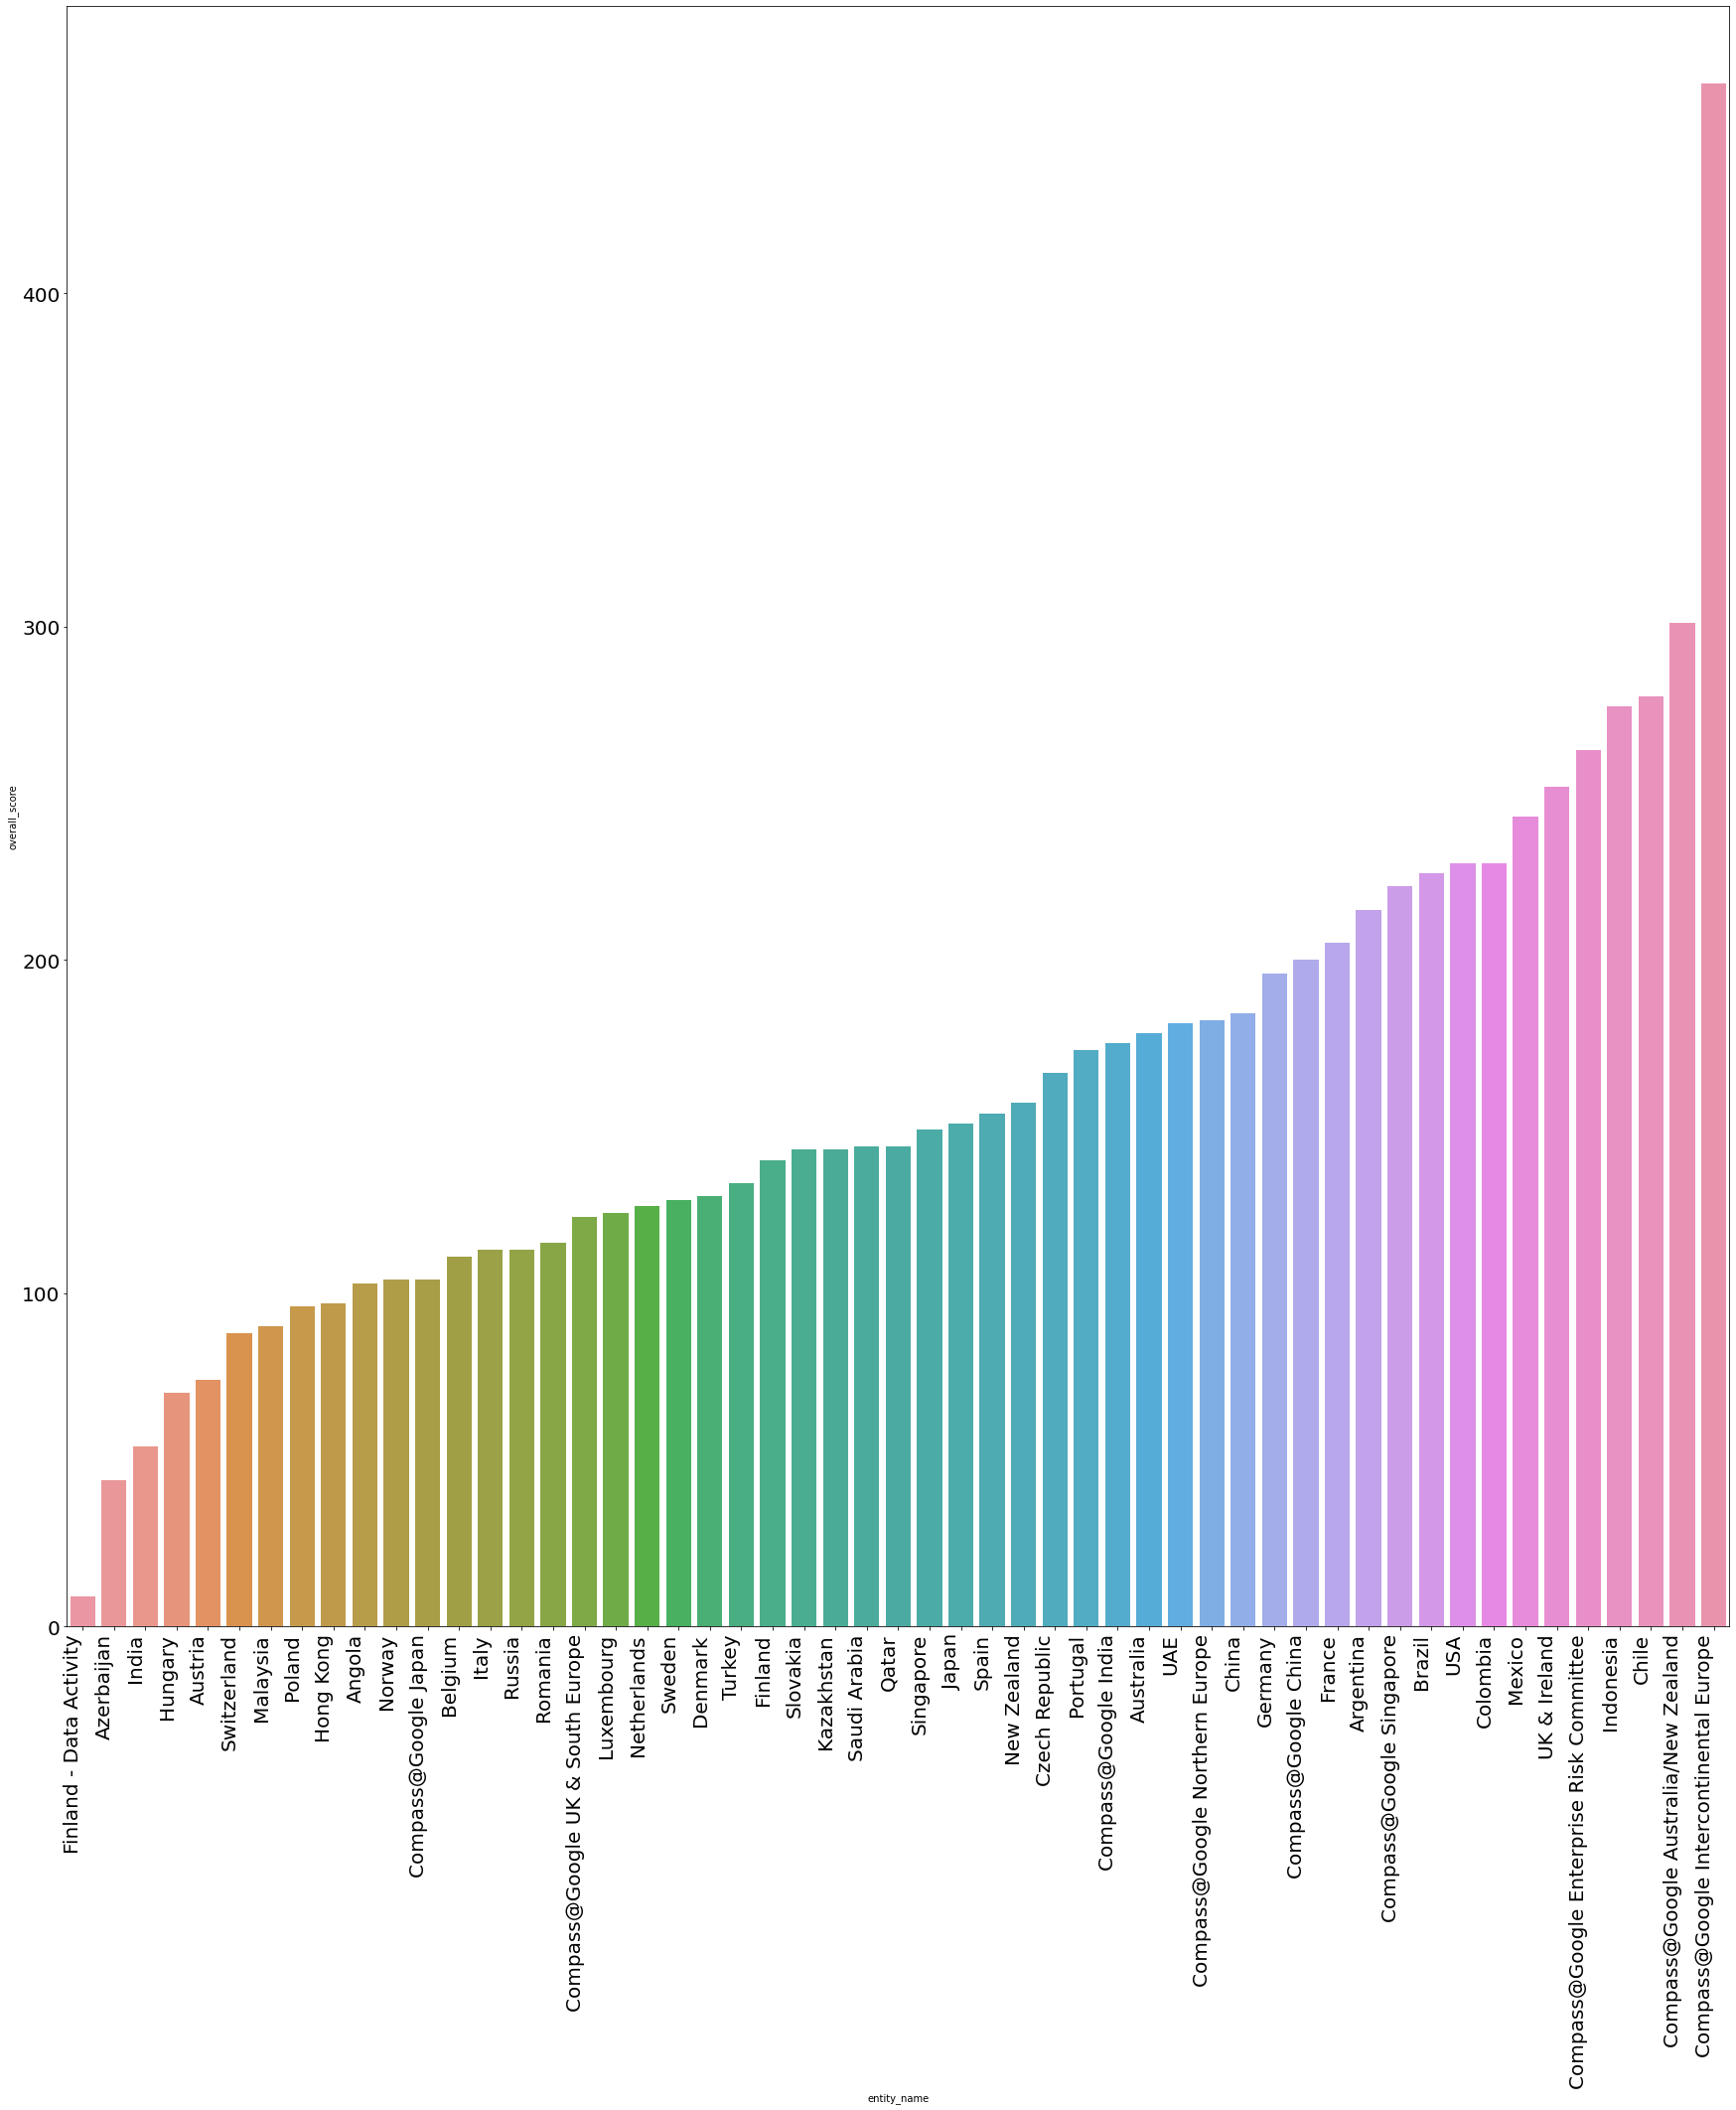

In [27]:
plt.pyplot.figure(figsize=[30,30])
plt.pyplot.xticks(fontsize=20, rotation = 90, ha="right")
plt.pyplot.yticks(fontsize=20)
sns.barplot(x="entity_name", y="overall_score", data=df_entities, order=df_entities.sort_values('overall_score').entity_name, hue_order=None, orient=None, color=None, palette=None)
#sns.scatterplot(data=df_entities, x="entity_name", y="overall_score", size="overall_score", legend=False, sizes=(200, 5000))

In [14]:
world_map.choropleth(
    geo_data=world_geo,
    data=df_can,
    columns=['Country', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Immigration to Canada'

SyntaxError: unexpected EOF while parsing (<ipython-input-14-ae1a740384c1>, line 9)

# 4. Identify the risks with the highest scores

In [15]:
df_risks = df.groupby(by=["risk_name"],as_index=False).sum()
df_risks.head(5)
#df.groupby(by=["b"], dropna=False).sum()
#df_entities.head(40)
#df.groupby(by=["b"], dropna=False).sum()
#plt.pyplot.figure(figsize=[20,10])
#plt.pyplot.xticks(fontsize=10, rotation = 45, ha="right")
#plt.pyplot.yticks(fontsize=10)
#sns.barplot(x="entity_name", y="overall_score", data=df_risks, order=None,hue_order=None, orient=None, color=None, palette=None)

,risk_name,id,likelihood,overall_impact,estimated_cost,status,entity_id,overall_score,survey_question,comments_count,...,Gross Exposure Rating,Last Gross Exposure Rating,Actions Taken to Reduce the Exposure.5,Supporting Evidence.5,Actions Taken to Reduce the Exposure.6,Supporting Evidence.6,Actions Taken to Reduce the Exposure.7,Supporting Evidence.7,Actions Taken to Reduce the Exposure.8,Supporting Evidence.8
0,Ability for D&T to deliver and support Compass...,20857,11,10,0.0,4,288,25,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ability for D&T to deliver the appropriate IT ...,6702,1,3,0.0,1,20,3,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Accidental Cyber Attack due to Employee,21961,29,32,0.0,11,860,83,0.0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Acquisition Integration and Divestments,36733,25,29,0.0,13,848,72,0.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adverse Publicity,71433,59,76,1000000.0,29,2653,166,0.0,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='risk_type', ylabel='overall_score'>

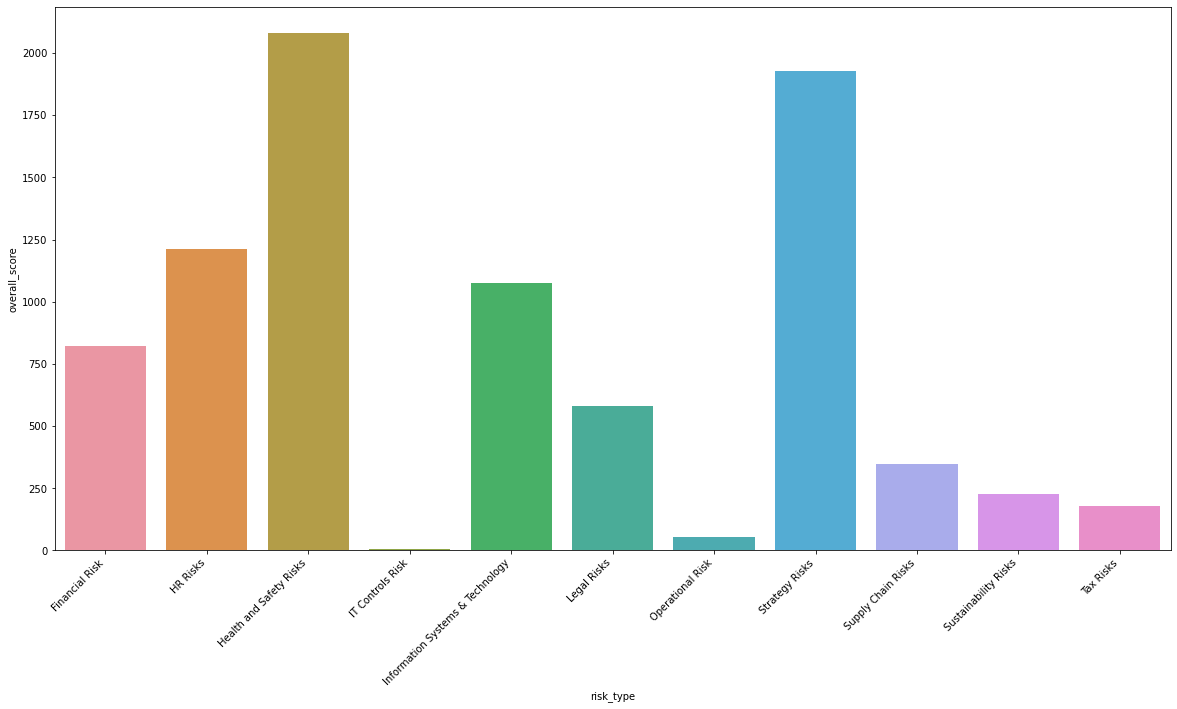

In [28]:
#Do risks per risk type risk_type
df_entities = df.groupby(by=["risk_type"],as_index=False).sum()
#df_entities.info()
df_entities.groupby(by=["overall_score"], dropna=False).sum()
plt.pyplot.figure(figsize=[20,10])
plt.pyplot.xticks(fontsize=10, rotation = 45, ha="right")
plt.pyplot.yticks(fontsize=10)
sns.barplot(x="risk_type", y="overall_score", data=df_entities, order=None, hue_order=None, orient=None, color=None, palette=None)

In [ ]:
#Do the layout of risk types




In [49]:
# Heatmap
#Do risks per risk type risk_type
df.groupby(by=['risk_name']).value_counts()
df_entities.info()
#df_entities.groupby(by=["overall_score"], dropna=False).sum()
#plt.pyplot.figure(figsize=[20,10])
#plt.pyplot.xticks(fontsize=10, rotation = 45, ha="right")
#plt.pyplot.yticks(fontsize=10)
#sns.barplot(x="risk_type", y="overall_score", data=df_entities, order=None, hue_order=None, orient=None, color=None, palette=None)

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'